# Neural & Behavioral Modeling - Week 12 (Exercises)
by 林子堯 (r08227112@ntu.edu.tw)

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
from tabulate import tabulate

In [2]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.7.0+cu101
Device  0 : Tesla T4
Current: Device  0


## 1 Fair Performance Evaluation (5 points)
We often compare and assess performances of different model architectures/parameters/hyperparameters. Note that the results are differnt even if you re-run exactly the same code block. This is primarily due to a non-fixed random number seed. Please:

(1) run the section 1.2 TEN times and report (a) min, (b) max, (c) mean, & (d) standard deviation of the TESTING accuracies. (3 points)

(2) try to fix the random number seeds in numpy & pytorch to see if you can obtain the same results every time in the section 1.2. (2 points)

### 1.0 CIFAR-10 dataset

In [3]:
# Load the dataset:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
train_set = CIFAR10(root='.', train=True, transform=transforms.ToTensor(), download=True)
train_data = t.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_set = CIFAR10(root='.', train=False, transform=transforms.ToTensor())
test_data = t.utils.data.DataLoader(train_set, batch_size=1000, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./cifar-10-python.tar.gz to .


### 1.1 The model

In [4]:
# Make the model:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # = nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 6, 5) # in, out, kernel
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1   = nn.Linear(16*5*5, 120) 
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x): # functional expressions
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x
lenet = Net()
lenet = lenet.to(device)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(lenet.parameters())

### 1.2 Training & Testing

In [7]:
# Training:
for e in range(2):
    for i, (X_train, Y_train) in enumerate(train_data, 0):
        X_train,Y_train=X_train.to(device),Y_train.to(device)
        Y_pred = lenet(X_train)
        loss = loss_fn(Y_pred, Y_train)
        lenet.zero_grad()
        loss.backward()
        optimizer.step()   
        Y_pred = lenet(X_train)
        Y_pred = t.max(Y_pred,1)[1]
    print('epoch ',e,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])
    
# Testing on a batch:
dataiter = iter(test_data)
X_test, Y_test = dataiter.next() # returning a batch
X_test,Y_test=X_test.to(device),Y_test.to(device)
with t.no_grad():
    Y_pred = lenet(X_test)
    Y_pred = t.max(Y_pred,1)[1]
    print('test :',(Y_pred==Y_test).sum().item()/Y_test.shape[0])

epoch  0 : 0.375
epoch  1 : 0.5625
test : 0.521


### 1.3 Your answers

方便起見，下方我重新將老師的範例程式包在 class 中。

In [10]:
class Simulation:
  def __init__(self):
    self.train_acc = None
    self.test_acc = None
    self.times = None
  
  def run_simulation(self, times=1, random_seed=None):
    self.train_acc, self.test_acc = np.zeros(times), np.zeros(times)
    self.times = times

    for time in range(times):   
      if random_seed is not None:
        t.manual_seed(random_seed)
        t.cuda.manual_seed(random_seed)
        t.cuda.manual_seed_all(random_seed)  # if you are using multi-GPU.
        #np.random.seed(seed)  # Numpy module.
        #random.seed(seed)  # Python random module.
        #t.manual_seed(seed)
        t.backends.cudnn.benchmark = False
        t.backends.cudnn.deterministic = True
        # ref: https://github.com/pytorch/pytorch/issues/7068#issuecomment-679568312

      # Built model:
      lenet = Net()
      lenet = lenet.to(device)
      loss_fn = t.nn.CrossEntropyLoss()
      optimizer = t.optim.Adam(lenet.parameters())

      # Training:
      for e in range(2):
        for i, (X_train, Y_train) in enumerate(train_data, 0):
          X_train,Y_train=X_train.to(device),Y_train.to(device)
          Y_pred = lenet(X_train)
          loss = loss_fn(Y_pred, Y_train)
          lenet.zero_grad()
          loss.backward()
          optimizer.step()   
          Y_pred = lenet(X_train)
          Y_pred = t.max(Y_pred,1)[1]
        # print('epoch ',e,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])
      self.train_acc[time] = ((Y_pred==Y_train).sum().item()/Y_train.shape[0])
        
      # Testing on a batch:
      dataiter = iter(test_data)
      X_test, Y_test = dataiter.next() # returning a batch
      X_test,Y_test=X_test.to(device),Y_test.to(device)
      with t.no_grad():
        Y_pred = lenet(X_test)
        Y_pred = t.max(Y_pred,1)[1]
        # print('test :',(Y_pred==Y_test).sum().item()/Y_test.shape[0])
      self.test_acc[time] = ((Y_pred==Y_test).sum().item()/Y_test.shape[0])

  def print_result(self):
    print(tabulate([['N', self.times],
            ['Min', self.test_acc.min()], 
            ['Mean', self.test_acc.mean()],
            ['Max', self.test_acc.max()],
            ['Standard deviaion', self.test_acc.std()]], 
            headers=['Statistic', 'Value'], tablefmt='orgtbl'))
      

下方為隨機訓練模型重複 10 次(每次的 epoch 都只有 2)，不然發現每一次的 test accuracy 都是不一樣的。

In [8]:
s_random = Simulation()
s_random.run_simulation(times = 10)
print(s_random.test_acc)
s_random.print_result()

[0.512 0.527 0.471 0.524 0.527 0.55  0.483 0.521 0.517 0.516]
| Statistic         |     Value |
|-------------------+-----------|
| N                 | 10        |
| Min               |  0.471    |
| Mean              |  0.5148   |
| Max               |  0.55     |
| Standard deviaion |  0.021456 |


如果我們給予固定的 random seed 數值，就能得到相同的結果。

**註：**這邊可能需要注意 PyTorch random seed 的寫法，可能需要考慮到再現同樣的結果時，不同人可能是用 CPU 或是 GPU 跑。詳細寫法可以參考：https://github.com/pytorch/pytorch/issues/7068#issuecomment-679568312

In [13]:
s_fixed = Simulation()
s_fixed.run_simulation(times = 10, random_seed = 6666)
print(s_fixed.test_acc)
s_fixed.print_result()

[0.547 0.547 0.547 0.547 0.547 0.547 0.547 0.547 0.547 0.547]
| Statistic         |        Value |
|-------------------+--------------|
| N                 | 10           |
| Min               |  0.547       |
| Mean              |  0.547       |
| Max               |  0.547       |
| Standard deviaion |  1.11022e-16 |


## 2 Universal Approximation Theorem (5 points)

Please FAIRLY evaluate whether a deep network learns XOR more efficiently than a shallow network with the same number of model parameters. Please discuss why in either case.

### 2.0 XOR data

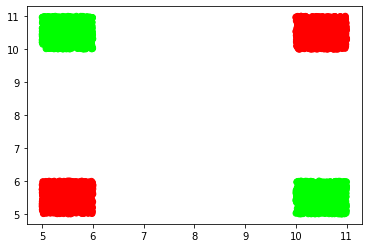

In [14]:
N=1000 # samples per cluster
XY=t.tensor([[5,5],[5,10],[10,5],[10,10]],dtype=t.float32) # 4 cluster centers
Z=t.tensor([0,1,1,0]) # category labels
t.cat([t.randn(2,1)+XY[0,0],t.randn(2,1)+XY[0,1]],1)
xy,z=t.zeros(4*N,2),t.zeros(4*N,dtype=t.int64)
for i in range(4):
    xy[i*N:(i+1)*N,]=t.rand(N,2)+XY[i,]
    z[i*N:(i+1)*N]=Z[i]
xy_np=xy.numpy()
z_np=z.numpy().astype(int)
cmap=np.array([[1,0,0],[0,1,0]])
scatter(xy_np[:,0],xy_np[:,1],color=cmap[z_np]);

#### 2.1 A shallow net with one hidden layer

In [ ]:
# Number of free parameters: 2*H+H*2=48

H=12 # number of hidden units
model = t.nn.Sequential(
    t.nn.Linear(2, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, 2, bias=False),
    t.nn.Softmax(dim=1)
)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters())

for i in range(100):
    z_pred = model(xy)
    loss = loss_fn(z_pred,z)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    z_pred = model(xy) 
    z_pred = t.max(z_pred,1)[1]
    print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])

#### 2.2 A "deep" net with three hidden layers

In [39]:

print(model.parameters("Linear"))

<generator object Module.parameters at 0x7f02ae05f4c0>


In [ ]:
# Number of free parameters: 2*H+H*H+H*H+H*2=48

H=4 # number of hidden units
model = t.nn.Sequential(
    t.nn.Linear(2, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H,bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, 2, bias=False),
    t.nn.Softmax(dim=1)
)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters())

for i in range(100):
    z_pred = model(xy)
    loss = loss_fn(z_pred,z)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    z_pred = model(xy) 
    z_pred = t.max(z_pred,1)[1]
    print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])

### 2.3 Your answers

#### 2.3.1 Shallow NN vs. Deep NN 之模擬比較

同樣也是方便起見，我將老師的範例程式重新包成一個 class 來執行，但為了比較兩者模型的學習效率，因此我有更改部分的程式碼。

In [16]:
class XORmodel:
  def __init__(self):
    self.shallow_times, self.shallow_epochs, self.shallow_accs = None, None, None
    self.deep_times, self.deep_epochs, self.deep_accs = None, None, None
  
  def run_shallow_nn(self, times = 10):
    self.shallow_times = times
    self.shallow_epochs = np.zeros(times)
    self.shallow_accs = np.zeros(times)

    for time in range(times):
      # Number of free parameters: 2*H+H*2=48
      H=12 # number of hidden units
      model = t.nn.Sequential(
        t.nn.Linear(2, H, bias=False),
        t.nn.BatchNorm1d(H),
        t.nn.ReLU(),
        t.nn.Linear(H, 2, bias=False),
        t.nn.Softmax(dim=1)
      )
      loss_fn = t.nn.CrossEntropyLoss()
      optimizer = t.optim.Adam(model.parameters())

      acc = 0
      epoch = 0
      while (acc < 1) and (epoch < 500) :
        z_pred = model(xy)
        loss = loss_fn(z_pred,z)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        z_pred = model(xy) 
        z_pred = t.max(z_pred,1)[1]
        acc = (z_pred==z).sum().item()/xy.shape[0]
        epoch += 1
      
      self.shallow_epochs[time] = epoch
      self.shallow_accs[time] = acc


  def run_deep_nn(self, times = 10):
    self.deep_times = times
    self.deep_epochs = np.zeros(times)
    self.deep_accs = np.zeros(times)

    for time in range(times):
      # Number of free parameters: 2*H+H*H+H*H+H*2=48
      H=4 # number of hidden units
      model = t.nn.Sequential(
        t.nn.Linear(2, H, bias=False),
        t.nn.BatchNorm1d(H),
        t.nn.ReLU(),
        t.nn.Linear(H, H,bias=False),
        t.nn.BatchNorm1d(H),
        t.nn.ReLU(),
        t.nn.Linear(H, H, bias=False),
        t.nn.BatchNorm1d(H),
        t.nn.ReLU(),
        t.nn.Linear(H, 2, bias=False),
        t.nn.Softmax(dim=1)
      )
      loss_fn = t.nn.CrossEntropyLoss()
      optimizer = t.optim.Adam(model.parameters())

      acc = 0
      epoch = 0
      while (acc < 1) and (epoch < 500):
        z_pred = model(xy)
        loss = loss_fn(z_pred,z)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        z_pred = model(xy) 
        z_pred = t.max(z_pred,1)[1]
        acc = (z_pred==z).sum().item()/xy.shape[0]
        epoch += 1

      self.deep_epochs[time] = epoch
      self.deep_accs[time] = acc

  def print_result(self):
    print(tabulate([['N', self.shallow_times, self.shallow_times, self.deep_times, self.deep_times],
            ['N epoch>=500 (acc<1.0)', sum(self.shallow_epochs>=500), sum(self.shallow_epochs>=500), sum(self.deep_epochs>=500), sum(self.deep_epochs>=500)],
            ['Min', self.shallow_epochs.min(), self.shallow_accs.min(), self.deep_epochs.min(), self.deep_accs.min()], 
            ['Mean', self.shallow_epochs.mean(), self.shallow_accs.mean(), self.deep_epochs.mean(), self.deep_accs.mean()],
            ['Max', self.shallow_epochs.max(), self.shallow_accs.max(), self.deep_epochs.max(), self.deep_accs.max()],
            ['Standard deviaion', self.shallow_epochs.std(), self.shallow_accs.std(), self.deep_epochs.std(), self.deep_accs.std()]], 
            headers=['Statistic', 'Shallow NN Epoch Number\n (censoring at 500)', 'Shallow NN Accuracy',  
                 'Deep NN Epoch Number\n (censoring at 500)', 'Deep NN Accuracy'], tablefmt='orgtbl'))

為了達到公平的判準，我將在 Shallow NN 與 Deep NN 分別跑 50 次，並且記錄每次學習需要多少次 epoch 才能達到準確率 100%，然而我還多加限定最多只能跑到 500 次 epoch，避免浪費太多時間。結果如下


In [32]:
t.manual_seed(7777)
x = XORmodel()
x.run_shallow_nn(times = 50)
x.run_deep_nn(times = 50)
x.print_result()

| Statistic              |   Shallow NN Epoch Number |   Shallow NN Accuracy |   Deep NN Epoch Number |   Deep NN Accuracy |
|                        |        (censoring at 500) |                       |     (censoring at 500) |                    |
|------------------------+---------------------------+-----------------------+------------------------+--------------------|
| N                      |                    50     |            50         |                 50     |          50        |
| N epoch>=500 (acc<1.0) |                     3     |             3         |                 16     |          16        |
| Min                    |                     1     |             0.75      |                 14     |           0.5      |
| Mean                   |                   126.96  |             0.993555  |                256.6   |           0.92492  |
| Max                    |                   500     |             1         |                500     |           1        |


從上表觀察中可發現，這兩種模型確實在 XOR 的問題上達到 100% 的準確率。然而就學習效率來說，在同樣的參數數目 (weights 各自都有 48 個且沒有 biaw parameter) 與超參數設定下，Shallow NN 學習的效率快於 Deep NN，前者的平均 epoch 數量比較小 (126.96<256.6) 且就平均準確率也較高 (0.99>0.92)。應該不需要做假設檢定就能發現之間是有明顯差異的

雖然說這兩者都有可能迭代到 500 epochs 時準確率依舊還達不到 100%，但在 50 次模擬中， Shallow NN 只有 3 個未完成，而 Deep NN 就有 1/3 次(= 16 次)是失敗的。因此總結來說，Shallow NN 在此問題上要比 Deep NN 來的好。

#### 2.3.2 原因探討：

同樣是 XOR 問題，我簡化原本題目給定的設定。假設 $X = (x)_{n \times 2}\in \{0, 1\}^{n \times 2}$ 為 input data, $Y = (y)_{n \times 2} \in \{0, 1\}^{n \times 2}$ 為 output data。 其中 Shallow NN 與 Deep NN 可以寫成

Shallow NN：

$$
\begin{align}
\underset{n \times 12}Z^{(1)} &= f^{(1)}(\underset{n \times 2}X \, \underset{2 \times 12}W^{(1)}) \\
\underset{n \times 2}{Y} &= s(\underset{n \times 12}Z^{(1)}\underset{12 \times 2}W^{(2)})
\end{align}
$$

Deep NN:

$$
\begin{align}
\underset{n \times 4}Z^{(1)} &= f^{(1)}(\underset{n \times 2}X \, \underset{2 \times 4}W^{(1)}) \\
\underset{n \times 4}Z^{(2)} &= f^{(2)}(\underset{n \times 4}Z^{(1)}\underset{4 \times 4}W^{(2)}) \\
\underset{n \times 4}Z^{(3)} &= f^{(3)}(\underset{n \times 4}Z^{(2)}\underset{4 \times 4}W^{(3)}) \\
\underset{n \times 2}Y &= s(\underset{n \times 4}Z^{(3)}\underset{4 \times 4}W^{(4)})
\end{align}
$$

其中 $Z$ 為隱藏層的輸出，$f_1(.), f_2(.), f_3()$ 皆為 ReLU function, $s(.)$ 為 softmax function。實際上這兩個模型可再寫為

Shallow NN:

$$
\begin{align}
Y &= g(X) = g(x_1, x_2) \\
&= s\left(\sum_{j=1}^{12} w_j^{(2)} \times f_{j}^{(1)}(\sum_{i=2}^2 w_{ji}^{(1)}x_i)\right)
\end{align}
$$

Deep NN:

$$
\begin{align}
Y &= g'(X) = g'(x_1, x_2) \\
&= s\left(\sum_{l=1}^{4} w_{l}^{(4)} \times f_{l}^{(3)}(\sum_{k=1}^{4} w_{lk}^{(3)} \times f_{k}^{(2)}(\sum_{j=1}^{4} w_{kj}^{(2)}\times f_{j}^{(1)}(\sum_{i=2}^2 w_{ji}^{(1)}x_i)))\right)
\end{align}
$$

雖然寫的「落落長」，但我想表達的是這兩種神經網路模型，其實在做的就是要去估計 $X$ 和 $Y$ 之間的對應關係，也就是上式中的 $g: X \mapsto Y$ 和 $g': X \mapsto Y$。若我們先忽略掉 softmax function 和 batch normalized 的部分，兩者之間的差異在於 shallow NN 中的 $X$ 只經過一次的非線性的轉換，而 deep NN 中的 $X$ 卻經過三次的非線性轉換。我們可以想像 deep NN 應該能比 shallow NN 更可以描繪出更複雜的 $X$ 之間的關係，例如 $X$ 之間的交互作用或是高次項...等，因此很容易去建立 $X$ $Y$ 之間複雜的函數關係，這也是為何現今大家比較偏好 deep NN 的原因之一(ref: https://stats.stackexchange.com/questions/182734/what-is-the-difference-between-a-neural-network-and-a-deep-neural-network-and-w)。

然而其代價就是，deep NN 面對較簡易的情境，像是這次的 XOR 分類問題，太複雜的模型結構 (一堆非線性轉換) 可能會使得學習效率較差，參數在迭代更新時可能落入區域極值，或是需要較長的時間將複雜的數學形式轉回簡單的對應關係。反而不像 shallow NN 要來的簡單明瞭，因此，在這此作業中可以發現 shallow NN 會學得比較快。當然，如果參數以及學習時間充裕的話，根據 Universal approximation theorem，兩者應該都能學得很好。

Shallow NN 圖示範例：

<img src="https://github.com/xup6y3ul6/Neural-and-Behavioral-Modeling/blob/main/12_Deep-learning%20Neural%20Networks%20(2-4)%20Convolutional%20Neural%20Network%20(CNN)/snn.png?raw=true" alt="drawing" width="500"/>


Deep NN 圖示範例：(可以注意三層隱藏層，其對 $X$ 的表徵越來越複雜)

<img src="https://github.com/xup6y3ul6/Neural-and-Behavioral-Modeling/blob/main/12_Deep-learning%20Neural%20Networks%20(2-4)%20Convolutional%20Neural%20Network%20(CNN)/dnn.png?raw=true" alt="drawing" width="500"/>

Deep NN 圖示失敗範例：

<img src="https://github.com/xup6y3ul6/Neural-and-Behavioral-Modeling/blob/main/12_Deep-learning%20Neural%20Networks%20(2-4)%20Convolutional%20Neural%20Network%20(CNN)/dnn_fail.png?raw=true" alt="drawing" width="500"/>

可參考下方網站模擬：

- [A Neural Network Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.83918&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) $\leftarrow\leftarrow$ 感謝劉昱維介紹！
- [Neural Network demo — Preset: Binary Classifier for XOR](https://phiresky.github.io/neural-network-demo/)

